## EPA ESAT Algorithm Details

#### Summary
The details provided in this notebook are focused on describing two algorithms which are capable of meeting the constraints of PMF5, produce models which have a high correlation with the outputs of PMF5, and are able to generate models with a loss value that matches or is lower than PMF5. The algorithm used in PMF5, Multi-Linear Engine 2 (ME-2), was built upon the original ME-1 algorithm that is detailed in the publication by Pentti Paatero [*The Multilinear Engine: A Table-Driven, Least Squares Program for Solving Multilinear 
Problems, including the n-Way Parallel Factor Analysis Mode*](https://www.jstor.org/stable/1390831). The algorithm uses a modified conjugate gradient method using projection to maintain non-negativity of the factor profile matrix. The algorithm falls under the category of a semi-NMF algorithm, as not all the matrices are required to be positive. The reason for not fully enforcing non-negativity on the matrices is to help prevent a higher positive value bias due to having uncertainty and small values in the input datasets. Another reason was to allow datasets which may have small negative values in the inputs because of how the data was collected, where the input data represents a distribution rather than a single data point.

#### Algorithm Requirements
The constraints and requirements of the PMF5 algorithm which had to be considered in the new ESAT algorithms are:
 - The loss function had to remain the same as the ME2 loss function.
 - The output of ESAT must be able to produce results which have a high correlation with the ME2 output. Reproducing the output of ME2 exactly is highly improbable due to any differences in the update procedure and the randomness of the starting state.
   - A correlation of greater than 0.9 averaged across the factor profile, factor contributions and the concentration output.
   - A correlation of greater than 0.9 for the factor profile.
 - The algorithm needs to properly function when negative values are present in the input data, and allow for negative values to be present in the factor contribution matrix.
 - The output model needs to have a loss value that is comparable to PMF5.
 - The algorithm should be as fast or faster than ME2.
#### Loss Function
The loss function that is used in ME2, and is described in the PMF5 User's Manual is defined as:
$$ Q = \sum_{i=1}^n \sum_{j=1}^m \bigg[ \frac{V_{ij} - \sum_{k=1}^K W_{ik} H_{kj}}{U_{ij}} \bigg]^2 $$
here $V$ is the input data matrix of features (columns=$M$) by samples (rows=$N$), $U$ is the uncertainty matrix of the input data matrix, $W$ is the factor contribution matrix of samples by factors=$k$, $H$ is the factor profile of factors by features.

#### Convergence
These algorithms all use a similar convergence criteria as the stopping condition. PMF5 has a tiered approach which is described in the User's Manual. The two ESAT algorithms offers two parameters which can be used to adjust the convergence criteria and allow for tuning of the final output. The two parameters are *converge_delta* and *converge_n*, and is simply the number of steps, *converge_n* where the change in $Q$ is less than *converge_delta* the model is considered converged and updates stop. These values in testing are typically set to *converge_delta* = 0.1 and *converge_n* = 10 (these values were chosen to speed up model convergence during testing and development).

#### Initial Conditions
The performance of ESAT algorithms is very sensitive to the initial conditions of the model, in this case the choices for the $W$ and $H$ matrices. There are multiple methods for initialization that are typically used for NMF. The method used by PMF5/ME2 is unknown. For ESAT, we have provided three different methods of initialization:
 - Random sampling from a normal distribution using the square root of the mean values of the input dataset $V$ by row $N$ for $W$ and by column $M$ for $H$. This is the default method in most NMF packages.
 - K-Means clustering, where the input dataset is normalized (can also be clustered without normalization) and $k$ clusters calculated. Allocation of a factor to a cluster is set to 1.0 and all other values are equal to $\frac{1}{k}$.
 - C-Means clustering, also known as fuzzy k-means clustering. Which is similar to K-Means but assignment to a cluster is not a binary value but continuous as calculated by the distance to the cluster centroids and the ratio of those distances.
Other methods of initialization exist but these are what we are currently providing in NMF-src.

### NMF-PY Algorithms
We have implemented two algorithms, one of which fully satisfies the algorithm requirements stated above and another which satisfies all by the condition of allowing for negative values.

#### LS-NMF
The first algorithm option we provide is a well documented algorithm called *LS-NMF*, least-squares nmf, and is available in the R NMF package. The ls-nmf algorithm is documented in [*LS-NMF: A modified non-negative matrix factorization algorithm utilizing uncertainty estimates*](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-7-175) and the R NMF package can be found at [https://cran.r-project.org/web/packages/NMF/index.html](https://cran.r-project.org/web/packages/NMF/index.html). The ESAT versions of these algorithms converts the uncertainty of $U$ into weights defined as $Uw = \frac{1}{U^2}$. The update equations then become:

$$ H_{t+1} = H_t \circ \frac{W_t (V \circ Uw)}{W_t {((W_{t}H_{t}) \circ Uw)}} $$

$$ W_{t+1} = W_t \circ \frac{(V \circ Uw) H_{t+1}}{((W_{t}H_{t+1})\circ Uw )H_{t+1}} $$

The ls-nmf algorithm requires that all matrices be non-negative but is able to produce models with a lower loss value than PMF5 and is significantly faster than ME2. We include this algorithm as an option for when full non-negativity is permitted in the models because of the algorithm's performance and efficiency.

#### Weighted Semi-NMF
The weighted semi-nmf (ws-nmf) algorithm is a more complicated algorithm that more closely resembles the ME1 algorithm. The ws-nmf algorithm satisfies all of the requirements for a replacement algorithm of PMF5. The implemented algorithm was developed utilizing elements from two different publications, neither of which provided the complete algorithm we required for NMF-src. [*Semi-NMF and Weighted Semi-NMF Algorithms Comparison*](https://www2.dc.ufscar.br/~marcela/anaisKDMiLe2014/artigos/FULL/kdmile2014_Artigo15.pdf) provides an overview of the semi-nmf algorithm and part of the update equation for ws-nmf. [*Convex and Semi-Nonnegative Matrix Factorizations*](https://ieeexplore.ieee.org/abstract/document/4685898) provides details on a complete algorithm for the non-weighted semi-nmf algorithm. Using these details we developed a complete update algorithm which may not yet have been published, further literature review is necessary to determine the novelty of the algorithm. 

As in the ls-nmf algorithm, the uncertainties are converted to weights $Uw$. In both algorithms, the loss function remains the same and uses the uncertainty and not the weights to maintain consistency with PMF5. The update equations for ws-nmf are:

$$ W_{t+1,i} = (H^{T}Uw_{i}^{d}H)^{-1}(H^{T}Uw_{i}^{d}V_{i})$$
$$ H_{t+1,i} = H_{t, i}\sqrt{\frac{((V^{T}Uw)W_{t+1})_{i}^{+} + [H_{t}(W_{t+1}^{T}Uw W)^{-}]_{i}}{((V^{T}Uw)W_{t+1})_{i}^{-} + [H_{t}(W_{t+1}^{T}Uw W)^{+}]_{i}}}$$

Each matrix requires a separate calculation for each sample=$N$ for $W$ and each feature=$M$ for $H$ and is indicated by the $i$ index, increasing the computational complexity of the algorithm. $Uw_{i}^{d}$ is the diagonal matrix created from the $i$th column or row of $Uw$ depending on which matrix is being updated. The first section of the update equation for $W_{t+1,i}$ requires calculating the inverse which is only possible if the determinant is not equal to zero, in which case the pseudo-inverse is used. The calculation of $H_{t+1}$ requires several additional steps. The positive and negative values from $W$ are separated with $W^{-} = \frac{(|W| - W)}{2.0}$ and $W^{+} = \frac{(|W| + W)}{2.0}$. 

#### Optimization
The algorithms are intended to be used directly as a python package, through Jupyter notebooks and eventually through a web application. With this in mind, the performance of the code must be considered during implementation. Here are a few approaches that have been taken to optimize the code/algorithm (with performance metrics shown later):
 1. Using Python 3.12
 2. Use of parallelization for batch modeling, fitting multiple models at a time.
 3. The algorithms have also be written in Rust, a low level language, which provides increased memory efficiency and decreased runtime.



### LS-NMF Example
Here is an example of how to use the code and generate either a single or multiple models

In [1]:
# Notebook imports
import os
import sys
import copy
import logging
import time
import json
import pandas as pd
import numpy as np
import plotly
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px
from plotly.subplots import make_subplots

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

##### Sample Datasets
PMF5 comes with three sample datasets which we will use in the code demo.

In [2]:
# Baton Rouge Dataset
br_input_file = os.path.join("D:\\", "projects", "esat", "data", "Dataset-BatonRouge-con.csv")
br_uncertainty_file = os.path.join("D:\\", "projects", "esat", "data", "Dataset-BatonRouge-unc.csv")
br_output_path = os.path.join("D:\\", "projects", "esat", "output", "BatonRouge")
# Baltimore Dataset
b_input_file = os.path.join("D:\\", "projects", "esat", "data", "Dataset-Baltimore_con.txt")
b_uncertainty_file = os.path.join("D:\\", "projects", "esat", "data", "Dataset-Baltimore_unc.txt")
b_output_path = os.path.join("D:\\", "projects", "esat", "output", "Baltimore")
# Saint Louis Dataset
sl_input_file = os.path.join("D:\\", "projects", "esat", "data", "Dataset-StLouis-con.csv")
sl_uncertainty_file = os.path.join("D:\\", "projects", "esat", "data", "Dataset-StLouis-unc.csv")
sl_output_path = os.path.join("D:\\", "projects", "esat", "output", "StLouis")

##### Code Imports
We import the modules for the model and a datahandler.

In [3]:
from esat.data.datahandler import DataHandler
from esat.model.sa import SA
from esat.model.batch_sa import BatchSA

##### Parameters

In [24]:
index_col = "Date"                  # the index of the input/uncertainty datasets
factors = 6                         # the number of factors
method = "ls-nmf"                   # "ls-nmf", "ws-nmf"
init_method = "col_means"           # default is column means "col_means", "kmeans", "cmeans"
init_norm = True                    # if init_method is either kmeans or cmeans, whether to normalize the data prior to clustering.
seed = 42                           # seed = 26586, most comparable model to PMF5 currently found
max_iterations = 20000              # the maximum number of iterations for fitting a model
converge_delta = 0.1                # convergence criteria for the change in loss, Q
converge_n = 10                     # convergence criteria for the number of steps where the loss changes by less than converge_delta
dataset = "br"                      # "br": Baton Rouge, "b": Baltimore, "sl": St Louis
verbose = True                      # adds more verbosity to the algorithm workflow on execution.
optimized = True                    # use the Rust code if possible

##### Load the Data

In [5]:
# Loading the Baton Rouge dataset
dh_br = DataHandler(
    input_path=br_input_file,
    uncertainty_path=br_uncertainty_file,
    index_col=index_col,
    sn_threshold=2.0
)
V_br, U_br = dh_br.get_data()            # Cleaned input dataset (numpy array), Cleaned uncertainty dataset (numpy array)

30-Apr-24 09:42:25 - Input and output configured successfully


##### Initialize and Train

In [6]:
# Training a single model
sa_br = SA(V=V_br, U=U_br, factors=factors, method=method, seed=seed, optimized=optimized, verbose=verbose)
sa_br.initialize(init_method=init_method, init_norm=init_norm, fuzziness=5.0)
sa_br.train(max_iter=max_iterations, converge_delta=converge_delta, converge_n=converge_n)

30-Apr-24 09:42:27 - R - Model: -1, Seed: 42, Q(true): 68313.7773, Q(robust): 58644.709, Steps: 1956/20000, Converged: True, Runtime: 1.27 sec


Here a single model was created that used the optimized Rust code with the ws-nmf algorithm. 940 iterations were taken before the convergence criteria was met with a resulting loss value of $Q=84264.11$.

In [25]:
%%time
# Training multiple models
models = 20                   # number of models to create
parallel = True               # execute training in parallel

batch_br = BatchSA(V=V_br, U=U_br, factors=factors, models=models, method=method, seed=seed, 
                   init_method=init_method, init_norm=init_norm,
                   max_iter=max_iterations, converge_delta=converge_delta,
                   converge_n=converge_n, parallel=parallel, optimized=optimized,
                   verbose=verbose
                   )
batch_br.train()

30-Apr-24 09:51:07 - Model: 1, Q(true): 65069.5744, Q(robust): 55644.9141, Seed: 8925, Converged: True, Steps: 2300/20000
30-Apr-24 09:51:07 - Model: 2, Q(true): 65541.8666, Q(robust): 55585.2486, Seed: 77395, Converged: True, Steps: 1291/20000
30-Apr-24 09:51:07 - Model: 3, Q(true): 65049.2052, Q(robust): 55589.223, Seed: 65457, Converged: True, Steps: 1348/20000
30-Apr-24 09:51:07 - Model: 4, Q(true): 66051.8651, Q(robust): 56544.1801, Seed: 43887, Converged: True, Steps: 1134/20000
30-Apr-24 09:51:07 - Model: 5, Q(true): 63928.0347, Q(robust): 54497.1779, Seed: 43301, Converged: True, Steps: 1495/20000
30-Apr-24 09:51:07 - Model: 6, Q(true): 63840.4524, Q(robust): 54423.8403, Seed: 85859, Converged: True, Steps: 2343/20000
30-Apr-24 09:51:07 - Model: 7, Q(true): 66533.3494, Q(robust): 56896.0526, Seed: 8594, Converged: True, Steps: 1011/20000
30-Apr-24 09:51:07 - Model: 8, Q(true): 65055.9772, Q(robust): 55644.0452, Seed: 69736, Converged: True, Steps: 2167/20000
30-Apr-24 09:51:07 

CPU times: total: 203 ms
Wall time: 7.37 s


(True, '')

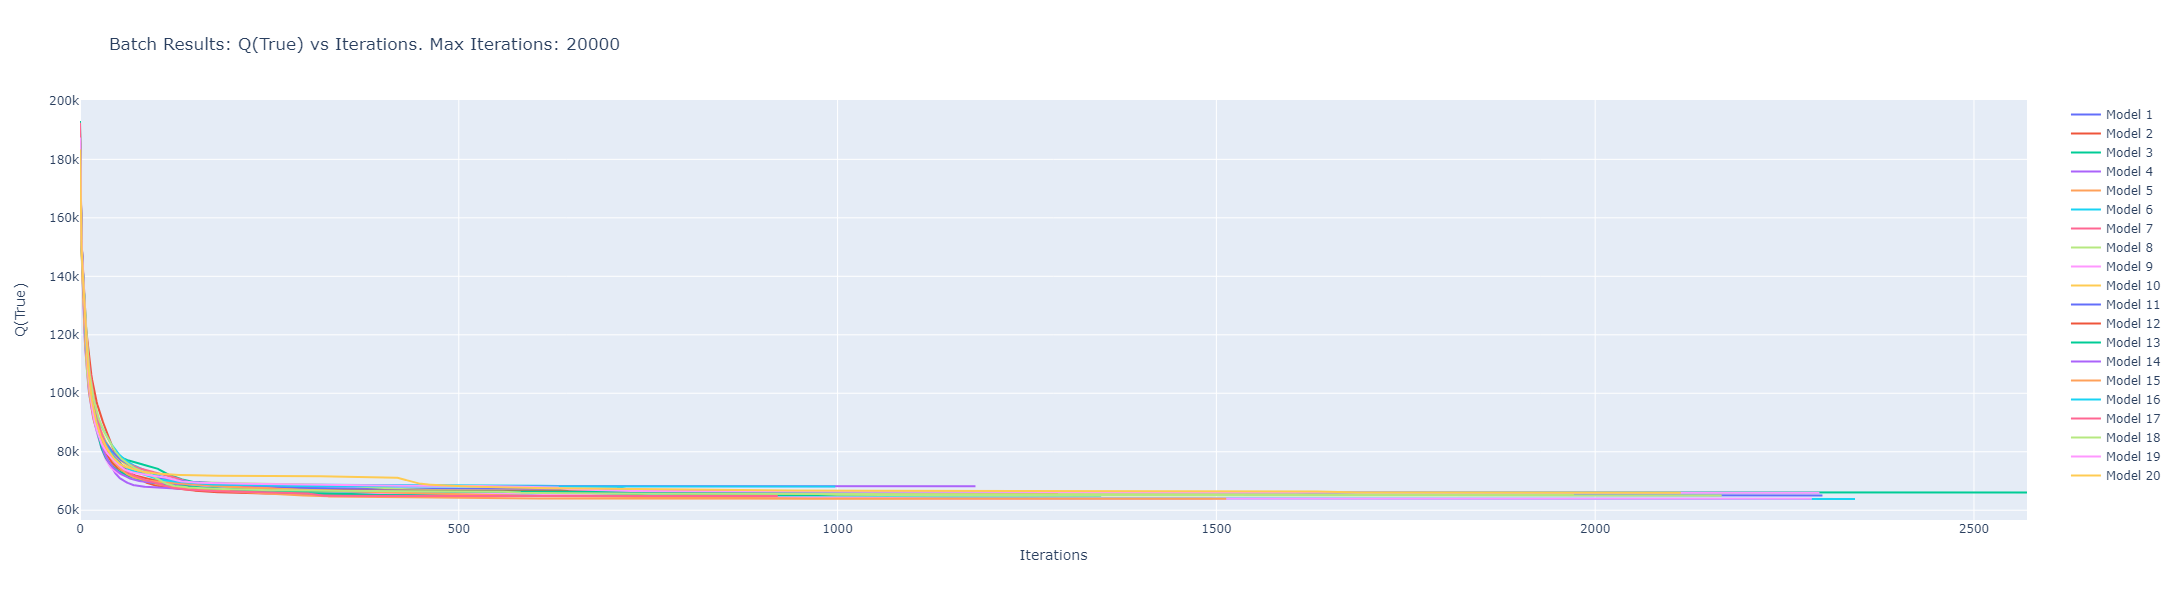

In [8]:
q_fig = go.Figure()
for i, result in enumerate(batch_br.results):
    if result is not None:
        q_fig.add_trace(go.Scatter(x=list(range(len(result.q_list))), y=result.q_list, name=f"Model {i+1}", mode='lines'))
q_fig.update(layout_title_text=f"Batch Results: Q(True) vs Iterations. Max Iterations: {batch_br.max_iter}")
q_fig.update_layout(width=1200, height=600, hovermode='x')
q_fig.update_xaxes(title_text="Iterations")
q_fig.update_yaxes(title_text="Q(True)")
q_fig.show()

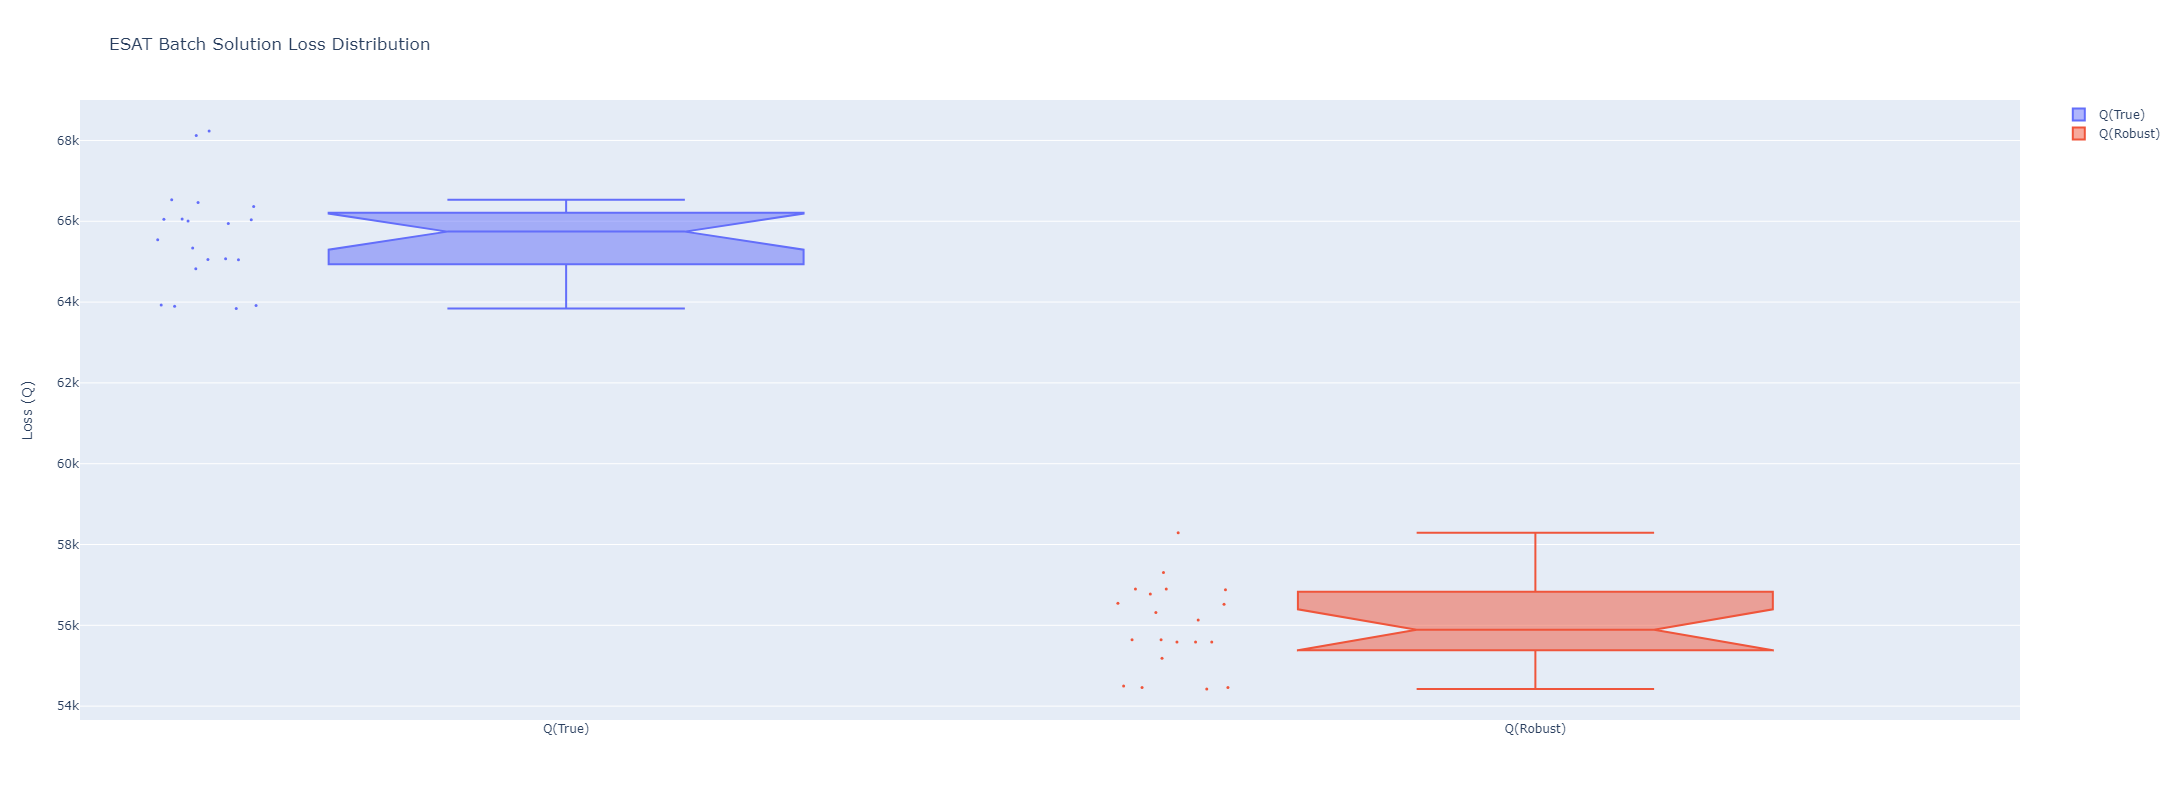

In [9]:
qt_list = []
qr_list = []
model = []
for i, result in enumerate(batch_br.results):
    if result is not None:
        model.append(i)
        qt_list.append(result.Qtrue)
        qr_list.append(result.Qrobust)

b_q_df = pd.DataFrame(data={"Q(True)":qt_list, "Q(Robust)":qr_list, 'Model':model})
b_q_fig = go.Figure(data=[
    go.Box(y=b_q_df['Q(True)'],boxpoints="all", notched=True, name="Q(True)", marker_size=3,text=model), 
    go.Box(y=b_q_df["Q(Robust)"],boxpoints="all", notched=True, name="Q(Robust)", marker_size=3, text=model)
])
b_q_fig.update(layout_title_text="ESAT Batch Solution Loss Distribution")
b_q_fig.update_yaxes(title_text="Loss (Q)")
b_q_fig.update_xaxes(title_text="")
b_q_fig.update_traces(hovertemplate='Model: %{text}<br>%{x}: %{y:.2f}<extra></extra>')
b_q_fig.update_layout(width=800, height=800)
b_q_fig.show()

In [10]:
selected_model = batch_br.results[batch_br.best_model]
H = selected_model.H
W = selected_model.W
V = V_br
U = U_br
Q = selected_model.Qtrue

In [38]:
# _W = np.matmul(V/U, H.T)
# print(f"W min: {_W.min()}, max: {_W.max()}")
# _W.shape
H_p = np.ones(shape=(3, V.shape[1]))
H_p[0].shape

(41,)

In [12]:
v_s = np.matmul(W, H)
residuals = np.subtract(V, v_s)
u_residuals = np.divide(residuals, U)
scaled_residuals = u_residuals**2

factor_q = []
for f_i in range(selected_model.factors):
    w_i = W[:, f_i]
    h_i = H[f_i]
    v_i = np.matmul(w_i.reshape(len(w_i), 1), [h_i])
    v_ip = v_i / v_s
    q_i = np.round(np.sum(scaled_residuals * v_ip), 4)
    factor_q.append(q_i)
    print(f"Factor {f_i} Q(True): {q_i}")
print(f"Q(true): {Q}, Q(test): {np.sum(factor_q)}")
H.shape

Factor 0 Q(True): 10235.0873
Factor 1 Q(True): 12551.5865
Factor 2 Q(True): 13662.2715
Factor 3 Q(True): 12976.4232
Factor 4 Q(True): 6530.2404
Factor 5 Q(True): 7884.8435
Q(true): 63840.45236634615, Q(test): 63840.4524


(6, 41)

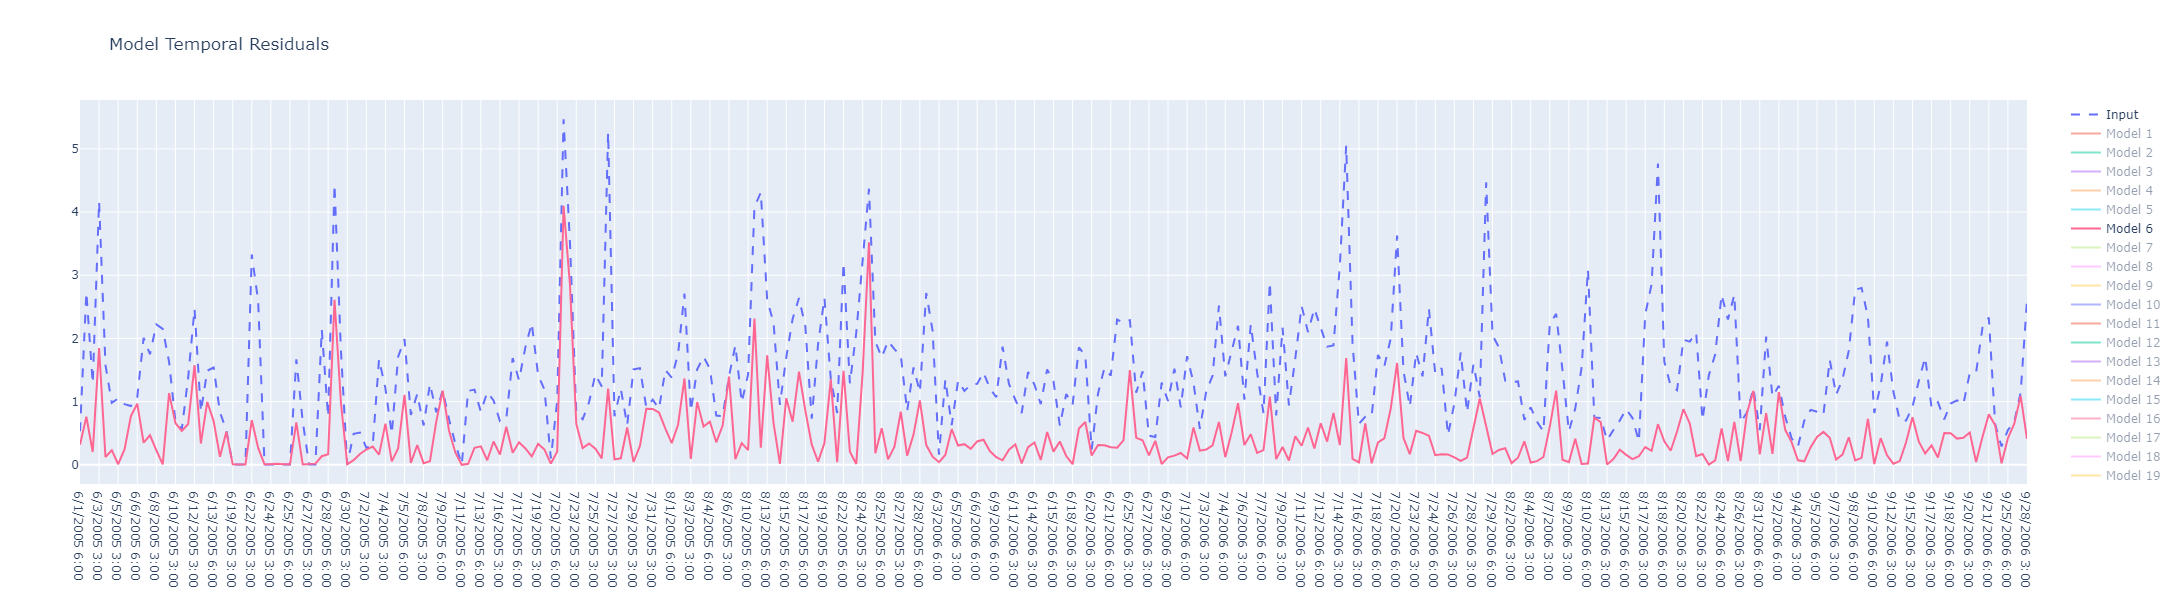

In [13]:
temporal_residuals = []
for i in range(0, len(batch_br.results)-1):
    result = batch_br.results[i]
    model_residual = np.abs(result.V - result.WH)
    temporal_residuals.append(model_residual)
x = dh_br.input_data_df.index
feature_i = 0
temporal_fig = go.Figure()
temporal_fig.add_trace(go.Scatter(x=x, y=batch_br.V[:,feature_i], name="Input", line=dict(dash='dash', width=2)))
for i, t in enumerate(temporal_residuals):
    visible = "legendonly"
    if i == batch_br.best_model:
        visible = True
    y = t[:,feature_i]
    temporal_fig.add_trace(go.Scatter(x=x, y=y, mode='lines', name=f"Model {i+1}", visible=visible))
temporal_fig.update_layout(title="Model Temporal Residuals", width=1200, height=600, hovermode='x')
temporal_fig.show()

In [14]:
# Imports for comparing to PMF5 outputs
from eval.factor_comparison import FactorCompare
from esat.metrics import calculate_Q

In [15]:
# Compare the results to the PMF5 output on the same dataset and the same number of factors
br_pmf_profile_file = os.path.join("D:\\", "projects", "esat", "data", "factor_test", f"br{factors}f_profiles.txt")
br_pmf_contribution_file = os.path.join("D:\\", "projects", "esat", "data", "factor_test", f"br{factors}f_contributions.txt")
br_pmf_residuals_file = os.path.join("D:\\", "projects", "esat", "data", "factor_test",
                                          f"br{factors}f_residuals.txt")
br_profile_comparison = FactorCompare(batch_sa=batch_br, pmf_profile_file=br_pmf_profile_file,
                                    pmf_contribution_file=br_pmf_contribution_file, factors=factors,
                                    features=dh_br.features, residuals_path=br_pmf_residuals_file)
br_pmf_q = calculate_Q(br_profile_comparison.pmf_residuals.values, dh_br.uncertainty_data_processed)
br_profile_comparison.compare(PMF_Q=br_pmf_q)

TypeError: FactorCompare.__init__() got an unexpected keyword argument 'pmf_profile_file'

Here we see that the most comparable NMF-PY model was model 5 from our batch of 10, with an average $R^2=0.848$ with a the breakdown for each factor and each of the matrices, plus the product matrix $WH$. Additionally, we are provided the factor mapping from the NMF-PY model to the PMF5 model, since the order of factors is never guaranteed to match. We are only comparing the outputs of NMF-PY to the single best performing model of PMF5.

In [ ]:
%%time
# Training multiple models using ls-nmf
models = 10                   # number of models to create
parallel = True               # execute training in parallel
method2 = "ws-nmf"

batch_br2 = BatchSA(V=V_br, U=U_br, factors=factors, models=models, method=method2, seed=seed, 
                    init_method=init_method, init_norm=init_norm,
                    max_iter=max_iterations, converge_delta=converge_delta,
                    converge_n=converge_n, parallel=parallel, optimized=optimized,
                    verbose=verbose
                   )
batch_br2.train()
# br2_full_output_path = f"br2_nmf-output-f{factors}.json"
# batch_br2.save(output_name=br2_full_output_path)

In [ ]:
br2_profile_comparison = FactorComp(batch_sa=batch_br2, pmf_profile_file=br_pmf_profile_file,
                                    pmf_contribution_file=br_pmf_contribution_file, factors=factors,
                                    features=dh_br.features, residuals_path=br_pmf_residuals_file)
br2_pmf_q = calculate_Q(br2_profile_comparison.pmf_residuals.values, dh_br.uncertainty_data_processed)
br2_profile_comparison.compare(PMF_Q=br2_pmf_q)

### Analysis

##### Q/Loss Comparison
Here the three different datasets were tested using both algorithms. 200 models were created for each dataset, each factor count, and each algorithm. The most compariable Q and $R^2$ are shown, along with the best performing (lowest Q) model Q is shown. The NaN were models that had not yet been completed. Each model requires a comparison of all permutations of the factor ordering to the PMF5 output, making comparison of factors > 5 time consuming to complete for 200 models. The $R^2$ value is the total average, the comparison of the factor profile (H matrix), the factor contribution (W matrix), and the model concentration output (WH).

In [ ]:
q_analysis_file = "q_analysis.json"
q_analysis = {}
with open(q_analysis_file, "r") as data_file:
    q_analysis = json.load(data_file)
q_df = pd.DataFrame(q_analysis.values())
q_df["dataset"].replace({"br": "Baton Rogue", "b": "Baltimore", "sl": "Saint Louis"}, inplace=True)
q_df.rename(columns={"Q(ls-nmf-R2)": "R2(ls-nmf)", "Q(ws-nmf-R2)": "R2(ws-nmf)"}, inplace=True)
q_df = q_df.round(decimals=4)
q_fig = ff.create_table(q_df)
q_fig.update_layout(width=1200, height=400)
q_fig.show()

In [ ]:
labels = q_df["dataset"] + " " + q_df["factors"].astype(str) + "f"
q_df["index"] = labels

q_sub = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=("Q/Loss Value", "Correlation to PMF (R2)"))

# runtime_df = runtime_df.sort_values(by=["dataset", "factors"], ascending=False)
pmf_trace = go.Bar(x=q_df["index"], y=q_df["Q(pmf)"], name="PMF")
ws_trace = go.Bar(x=q_df["index"], y=q_df["Q(ws-nmf)"], name="WS-NMF")
ls_trace = go.Bar(x=q_df["index"], y=q_df["Q(ls-nmf)"], name="LS-NMF")
q_sub.add_trace(pmf_trace, 1, 1)
q_sub.add_trace(ws_trace, 1, 1)
q_sub.add_trace(ls_trace, 1, 1)

ws_trace2 = go.Scatter(x=q_df["index"], y=q_df["R2(ws-nmf)"], name="R2 WS-NMF", mode='markers')
ls_trace2 = go.Scatter(x=q_df["index"], y=q_df["R2(ls-nmf)"], name="R2 LS-NMF", mode='markers')
ws_mean2 = go.Scatter(x=q_df["index"], y=[q_df["R2(ws-nmf)"].mean()] * len(labels), name="R2 WS-NMF Mean", mode='lines', line=dict(width=1, color='purple'))
ls_mean2 = go.Scatter(x=q_df["index"], y=[q_df["R2(ls-nmf)"].mean()] * len(labels), name="R2 LS-NMF Mean", mode='lines', line=dict(width=1, color='orange'))

q_sub.add_trace(ws_trace2, row=2, col=1)
q_sub.add_trace(ls_trace2, row=2, col=1)
q_sub.add_trace(ws_mean2, row=2, col=1)
q_sub.add_trace(ls_mean2, row=2, col=1)

q_sub.update_layout(height=600, width=1200, title_text="Q/Loss Comparison with Correlation")
q_sub.show()

print(f"Mean R2 - ls-nmf: {round(q_df['R2(ls-nmf)'].mean(),4)}, ws-nmf: {round(q_df['R2(ws-nmf)'].mean(),4)}")

In [ ]:
q_dif = cosrc.copy(q_df)
q_dif["Q dif(ls-nmf)"] = q_dif["Q(pmf)"] / q_df["Q(ls-nmf)"]
q_dif["Q dif(ws-nmf)"] = q_dif["Q(pmf)"] / q_df["Q(ws-nmf)"]
q_dif = q_dif.round(decimals=4)

q_dif_fig = ff.create_table(q_dif[["dataset", "factors", "R2(ls-nmf)", "R2(ws-nmf)", "Q dif(ls-nmf)", "Q dif(ws-nmf)"]])
q_dif_fig.update_layout(width=1200, height=400)
q_dif_fig.show()
print(f"Min Dif - ls-nmf: {q_dif['Q dif(ls-nmf)'].min()}, ws-nmf: {q_dif['Q dif(ws-nmf)'].min()}")
print(f"Max Dif - ls-nmf: {q_dif['Q dif(ls-nmf)'].max()}, ws-nmf: {q_dif['Q dif(ws-nmf)'].max()}")

##### Runtime Comparison

Here the runtime performance was measured for creating 10 models having comparable loss. The python code was run on the parallelized Rust functions and all values are in seconds.

In [ ]:
runtime_analysis_file = "runtime_analysis.json"
runtime_analysis = {}
with open(runtime_analysis_file, "r") as data_file:
    runtime_analysis = json.load(data_file)
runtime_df = pd.DataFrame(runtime_analysis.values())
runtime_df["dataset"].replace({"br": "Baton Rogue", "b": "Baltimore", "sl": "Saint Louis"}, inplace=True)
runtime_df = runtime_df.sort_values(by=["dataset", "factors"])
runtime_df = runtime_df.round(decimals=2)
runtime_fig = ff.create_table(runtime_df)
runtime_fig.update_layout(width=1200, height=600)

runtime_fig.show()

In [ ]:
labels = runtime_df["dataset"] + " " + runtime_df["factors"].astype(str) + "f"
runtime_df["index"] = labels

runtime_sub = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=("Runtime(sec)", "Q/Loss Value"))

rt_pmf_trace = go.Bar(x=runtime_df["index"], y=runtime_df["pmf-runtime"], name="PMF")
rt_ws_trace = go.Bar(x=runtime_df["index"], y=runtime_df["ws-nmf-runtime"], name="WS-NMF")
rt_ls_trace = go.Bar(x=runtime_df["index"], y=runtime_df["ls-nmf-runtime"], name="LS-NMF")
runtime_sub.add_trace(rt_pmf_trace, 1, 1)
runtime_sub.add_trace(rt_ws_trace, 1, 1)
runtime_sub.add_trace(rt_ls_trace, 1, 1)

pmf_trace2 = go.Scatter(x=runtime_df["index"], y=runtime_df["pmf-Q"], name="Q PMF", mode='lines')
ws_trace2 = go.Scatter(x=runtime_df["index"], y=runtime_df["ws-nmf-Q"], name="Q WS-NMF", mode='lines')
ls_trace2 = go.Scatter(x=runtime_df["index"], y=runtime_df["ls-nmf-Q"], name="Q LS-NMF", mode='lines')
runtime_sub.add_trace(pmf_trace2, row=2, col=1)
runtime_sub.add_trace(ws_trace2, row=2, col=1)
runtime_sub.add_trace(ls_trace2, row=2, col=1)

runtime_sub.update_layout(height=600, width=1200, title_text="Runtime Comparison with Q Values")
runtime_sub.show()

In [ ]:
labels = runtime_df["dataset"] + " " + runtime_df["factors"].astype(str) + "f"
runtime_df["index"] = labels

# runtime_df = runtime_df.sort_values(by=["dataset", "factors"], ascending=False)
pmf_trace = go.Bar(x=runtime_df["index"], y=runtime_df["pmf-runtime"], name="PMF")
ws_trace = go.Bar(x=runtime_df["index"], y=runtime_df["ws-nmf-runtime"], name="WS-NMF")
ls_trace = go.Bar(x=runtime_df["index"], y=runtime_df["ls-nmf-runtime"], name="LS-NMF")

runtime_fig2 = go.Figure(data=[pmf_trace, ws_trace, ls_trace])
runtime_fig2.update_layout(barmode='group')
runtime_fig2.layout.title = "Runtime Comparison - 20 Models (sec)"
runtime_fig2.layout.height = 500
runtime_fig2.layout.width = 1200
runtime_fig2.show()

In [ ]:
ls_runtime_metric = (runtime_df['ls-nmf-runtime'] / runtime_df['factors']).mean()
ws_runtime_metric = (runtime_df['ws-nmf-runtime'] / runtime_df['factors']).mean()
pmf_runtime_metric = (runtime_df['pmf-runtime'] / runtime_df['factors']).mean()
print(f"Ratio of runtime to factor count - LS-NMF: {round(ls_runtime_metric,3)}, WS-NMF: {round(ws_runtime_metric,3)}, PMF: {round(pmf_runtime_metric,3)}")

In [ ]:
type_runtime_analysis_file = "type_runtime_analysis.json"
type_runtime_analysis = {}
with open(type_runtime_analysis_file, "r") as data_file:
    type_runtime_analysis = json.load(data_file)
type_runtime_df = pd.DataFrame(type_runtime_analysis.values())
type_runtime_df["dataset"].replace({"br": "Baton Rogue", "b": "Baltimore", "sl": "Saint Louis"}, inplace=True)
type_runtime_df = type_runtime_df.sort_values(by=["dataset", "factors"])
type_runtime_fig = ff.create_table(type_runtime_df)
type_runtime_fig.show()

In [ ]:
type_labels = type_runtime_df["dataset"] + " " + type_runtime_df["factors"].astype(str) + "f"
type_runtime_df["index"] = type_labels

ws_py_trace = go.Bar(x=type_runtime_df["index"], y=type_runtime_df["ws-nmf-py-runtime"], name="WS-NMF(PY)")
ls_pu_trace = go.Bar(x=type_runtime_df["index"], y=type_runtime_df["ls-nmf-py-runtime"], name="LS-NMF(PY)")
ws_trace = go.Bar(x=type_runtime_df["index"], y=type_runtime_df["ws-nmf-rust-runtime"], name="WS-NMF(RUST)")
ls_trace = go.Bar(x=type_runtime_df["index"], y=type_runtime_df["ls-nmf-rust-runtime"], name="LS-NMF(RUST)")

type_runtime_fig2 = go.Figure(data=[ws_py_trace, ws_trace, ls_pu_trace, ls_trace])
type_runtime_fig2.update_layout(barmode='group')
type_runtime_fig2.layout.title = "Runtime Type Comparison - 10 Models (sec)"
type_runtime_fig2.layout.height = 500
type_runtime_fig2.show()

#### Factor Comparison

Here we look at the best model produced by PMF5 for the Baton Rouge dataset using 6 factors, that is the model with the lowest Q(robust), and compare that model to the most comparable models from the LS-NMF and WS-NMF algorithms. Each algorithm generated 200 models and each of those model's output was compared to the PMF5 model, checking the $R^2$ of each model factor permutation (since mapping the factor order may be different from NMF-PY to PMF5). $R^2$ is calculated for the factor profile ($H$), the factor contributions ($W$), and the model product output ($WH$). The best model is determined as the model with the highest $R^2$ average. 

In [ ]:
# PMF5 input files are converted into pandas dataframes 
factors = 6

pmf_profile_file = os.path.join("D:\\", "projects", "nmf_py", "data", "factor_test", f"br{factors}f_profiles.txt")
pmf_contribution_file = os.path.join("D:\\", "projects", "nmf_py", "data", "factor_test", f"br{factors}f_contributions.txt")
pmf_residuals_file = os.path.join("D:\\", "projects", "nmf_py", "data", "factor_test", f"br{factors}f_residuals.txt")

pmf_output = FactorComp(pmf_profile_file=pmf_profile_file, pmf_contribution_file=pmf_contribution_file, residuals_path=pmf_residuals_file, factors=factors, features=dh_br.features)

In [ ]:
# LS-NMF and WS-NMF data pre-processing

profile_comparison_file = os.path.join("profile_compare_analysis_2.json")
profile_json = {}
with open(profile_comparison_file, "r") as p_file:
    profile_json = json.load(p_file)
    
ls_key = "br-6-ls-nmf"
ws_key = "br-6-ws-nmf"

zero_threshold = 1e-6

species = pmf_output.pmf_profiles_df["species"]
profile_columns = [ f"Factor {i}" for i in range(1, 7)]

ls_mapping = profile_json[ls_key]["factor_mapping"]
ws_mapping = profile_json[ws_key]["factor_mapping"]

ls_profiles = pd.DataFrame(np.array(profile_json[ls_key]["model_profiles"]).T, columns=profile_columns)
ls_profiles[ls_profiles < zero_threshold] = 0.0
ls_profiles["species"] = species
ws_profiles = pd.DataFrame(np.array(profile_json[ws_key]["model_profiles"]).T, columns=profile_columns)
ws_profiles[ws_profiles < zero_threshold] = 0.0
ws_profiles["species"] = species

datetimestamps = pmf_output.pmf_contribution_df["Datetime"].tolist()
ls_contributions = pd.DataFrame(np.array(profile_json[ls_key]["model_contributions"]), columns=profile_columns)
ls_contributions["Datetime"] = datetimestamps
ws_contributions = pd.DataFrame(np.array(profile_json[ws_key]["model_contributions"]), columns=profile_columns)
ws_contributions["Datetime"] = datetimestamps

input_df = dh_br.input_data
input_df["Date"] = pd.to_datetime(datetimestamps, format="%m/%d/%y %H:%M")
input_df.set_index("Date", inplace=True)

In [ ]:
from esat.data.test_tools import CompareAnalyzer

In [ ]:
ca = CompareAnalyzer(input_df=dh_br.input_data, 
                     pmf_profile_df=pmf_output.pmf_profiles_df, ls_profile_df=ls_profiles, ws_profile_df=ws_profiles, 
                     pmf_contributions_df=pmf_output.pmf_contribution_df, ls_contributions_df=ls_contributions, ws_contributions_df=ws_contributions,
                     ls_mapping=ls_mapping, ws_mapping=ws_mapping,
                     features=species,
                     datetimestamps=datetimestamps
                    )

In [ ]:
ca.plot_factor_contribution(feature_i=2)

In [ ]:
ca.plot_fingerprints(ls_nmf_r2=profile_json[ls_key]["model_profile_r2"], ws_nmf_r2=profile_json[ws_key]["model_profile_r2"])

In [ ]:
ca.plot_factors()

In [ ]:
ca.plot_feature_timeseries(factor_n=3, feature_n=range(0, 2))

In [ ]:
ca.feature_histogram(feature_i=1)

In [ ]:
ca.timeseries_plot(feature_i=0)